In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import glob
import pylab as pl
import numpy as np
import matplotlib.animation as animation
import types
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import matplotlib.patches as patches
% matplotlib inline

In [2]:
nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/min_ice/para60Run/result/ENG319582008.nc'))#*_ptrc_T*.nc'))
print("found *.nc file: \n{}".format(nc_filename))
ptrc=nc.Dataset(nc_filename[0])

found *.nc file: 
['/ocean/xiaoxiny/research/result_jasper/min_ice/para60Run/result/ENG319582008.nc']


In [3]:
lon=ptrc.variables['nav_lon'][:,:]
lat=ptrc.variables['nav_lat'][:,:]
dep = ptrc.variables['deptht'][:]


tmask=nc.Dataset(
        '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc')
mbathy=tmask.variables['mbathy'][0,400:,:]
tmask=tmask.variables['tmask'][0,:,400:,:]


bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]

In [4]:
uvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridU_19692008.nc')
vvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridV_19692008.nc')
wvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridW_19692008.nc')

In [5]:
yearnum=len(ptrc.variables['TR_7'][:,0,0,0])

In [6]:
def map():
    m = Basemap(projection='npstere',boundinglat=67,lon_0=0,resolution='l',round='TRUE')
    m.drawcoastlines()
    m.fillcontinents(color = '0.75')
    m.drawparallels(np.arange(70.,80.,2.),labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[0, 0, 1, 1])
    x_lon,y_lat = m(lon,lat)
    m.plot(x_lon[::10,::10],y_lat[::10,::10],x_lon.T[::10,::10],y_lat.T[::10,::10],color='k',linewidth=0.1)
    #m.plot(x_lon[::100,::10].T,y_lat[::100,::10].T,color='b')
    cs=m.contour(x_lon,y_lat,bathy,linewidth=0.075,colors='black',alpha=0.3)
    return m,x_lon,y_lat

# find cross Canada profile (2)
def section(x0,y0,length,xi,yi):
    '''xi = 1 then x0-i
          = 0 then x0=i
    same for yi'''
    a=[]
    b=[]
    for i in range (length):
        a.append(x_lon[x0+xi*i,y0+yi*i])
        b.append(y_lat[x0+xi*i,y0+yi*i])
    return a,b



In [7]:
def section_vprof(data,time,x0,y0,length,xi,yi):
    '''load data for vertial profiel'''
    a=np.empty([dep.shape[0],length]);
    vlat=np.empty(length)
    signx=(-1)**xi
    signy=(-1)**yi
    for i in range (length):
        temp=data[time,:,x0+signx*i,y0+signy*i]
        temp=np.ma.masked_where(tmask[:,x0+signx*i,y0+signy*i]<=0,temp)
        
        a[:,i]=temp
        vlat[i]=lat[x0+signx*i,y0+signy*i]
    return a,vlat

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


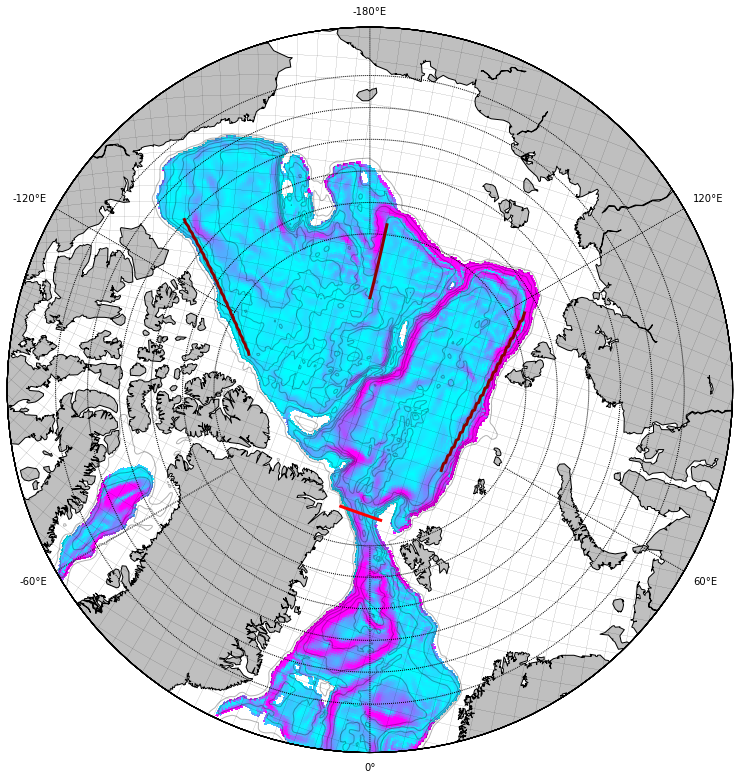

In [8]:
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot()
m,x_lon,y_lat=map()
#sec1 Makarov
#m.plot(x_lon[-135:-115,330],y_lat[-135:-115,330],color='orangered',lw=3)
a_mb,b_mb=section(x0=-145,y0=290,length=40,xi=1,yi=0)
m.plot(a_mb[:],b_mb[:],color='darkred',linewidth=3)


#sec3 Nansen
a_ns,b_ns=section(x0=-230,y0=358,length=100,xi=1,yi=0.2)
m.plot(a_ns[:],b_ns[:],color='darkred',linewidth=3)

#sec4 Fram starit
m.plot(x_lon[-265,310:335],y_lat[-265,310:335],color='r',linewidth=3)


#sec5 CB
a_,b_=section(x0=280,y0=170,length=40,xi=-2,yi=1.5)
m.plot(a_[:],b_[:],color='darkred',linewidth=3)

#a_,b_=section(x0=280,y0=175,length=25,xi=-1,yi=1)
#m.plot(a_[:],b_[:],color='darkred',linewidth=3)

data =(uvel.variables['vozocrtx'][5,35,400:,:]**2+vvel.variables['vomecrty'][5,35,400:,:]**2)**0.5
m.pcolor(x_lon,y_lat,data[:,:],cmap='cool',vmax=0.04)

[CB](#another_cell)

In [12]:
time_plt=np.linspace(1958,1958+yearnum-1,yearnum)

In [10]:
def section_hovmoller(data,layer,x0,y0,length,xi,yi):
    '''load data for vertial profiel'''
    a=np.empty([yearnum,length]);
    vlat=np.empty(length)
    signx=xi
    signy=yi
    for i in range (length):
        temp=data[:,layer,x0+signx*i,y0+signy*i]
        temp=np.ma.masked_where(tmask[layer,x0+signx*i,y0+signy*i]<=0,temp)
        a[:,i]=temp
        vlat[i]=lon[x0+signx*i,y0+signy*i]
    return a,vlat

In [11]:
def vvelocity_hov(layer,length,x0,y0,xi,yi):
    a=np.empty([length]);
    vlat=np.empty(length)


    signx=xi;signy=yi
    zi=(yi**2+xi**2)**0.5
    hold=np.empty([yearnum,length]);
    for j in range (yearnum):
        u=vel(keyword='U',T=1958+j,ENG='ENG3')[layer,:,:]
        v=vel(keyword='V',T=1958+j,ENG='ENG3')[layer,:,:]
        
        for i in range (length):
                temp=u[x0+signx*i,y0+signy*i]*yi/zi+v[x0+signx*i,y0+signy*i]*xi/zi
                temp=np.ma.masked_where(tmask[layer,x0+signx*i,y0+signy*i]<=0,temp)
                a[i]=temp
                vlat[i]=lon[x0+signx*i,y0+signy*i]
        hold[j,:]=a[:]
    return hold,vlat


def uvelocity_hov(layer,length,x0,y0,xi,yi):
    a=np.empty([length]);
    vlat=np.empty(length)


    signx=xi;signy=yi
    zi=(yi**2+xi**2)**0.5
    hold=np.empty([yearnum,length]);
    for j in range (yearnum):
        u=vel(keyword='U',T=1958+j,ENG='ENG3')[layer,:,:]
        v=vel(keyword='V',T=1958+j,ENG='ENG3')[layer,:,:]
        for i in range (length):
                temp=u[x0+signx*i,y0+signy*i]*xi/zi+v[x0+signx*i,y0+signy*i]*yi/zi
                temp=np.ma.masked_where(tmask[layer,x0+signx*i,y0+signy*i]<=0,temp)
                a[i]=temp
                vlat[i]=lon[x0+signx*i,y0+signy*i]
        hold[j,:]=a[:]
    return hold,vlat

In [13]:
def vel(keyword,T,ENG='ENG3'):
    'design to obtain velocity field'
    if keyword =='U':
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*U*%s.nc'%(ENG,T)))
        #print (nc_filename)
        uvel=nc.Dataset(nc_filename[0])
        data =uvel.variables['vozocrtx'][0,:,400:,:]
    elif keyword =='V':
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*V*%s.nc'%(ENG,T)))
        vvel=nc.Dataset(nc_filename[0])
        data =vvel.variables['vomecrty'][0,:,400:,:]
    else:
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*W*%s.nc'%(ENG,T)))
        wvel=nc.Dataset(nc_filename[0])
        data =wvel.variables['vovecrtz'][0,:,400:,:]
    data =np.ma.masked_where(tmask==0,data)
    return data

# MB tracer

In [73]:
temp,coor=section_hovmoller(data=ptrc.variables['TR_7'],layer=35,x0=-145,y0=290,length=40,xi=1,yi=0)
temp2,coor=section_hovmoller(data=ptrc.variables['TR_8'],layer=35,x0=-145,y0=290,length=40,xi=1,yi=0)
# vel
uhold,vlat= uvelocity_hov(layer=35,x0=-145,y0=290,length=40,xi=1,yi=0)
vhold,vlat= vvelocity_hov(layer=35,x0=-145,y0=290,length=40,xi=1,yi=0)

In [74]:
Temp=temp[:,:]/temp2[:,:]
Temp=np.ma.masked_where(temp==0,Temp)

In [75]:
ptemp1,coor=section_hovmoller(data=ptrc.variables['TR_9'],layer=35,x0=-145,y0=290,length=40,xi=1,yi=0)
ptemp1=np.ma.masked_where(ptemp1==0,ptemp1)
ptemp2,coor=section_hovmoller(data=ptrc.variables['TR_10'],layer=35,x0=-145,y0=290,length=40,xi=1,yi=0)
ptemp2=np.ma.masked_where(ptemp2==0,ptemp2)

pTemp=ptemp1[:,:]/ptemp2[:,:]
pTemp=np.ma.masked_where(pTemp==0,pTemp)

(174.10356140136719, 179.98170471191406)

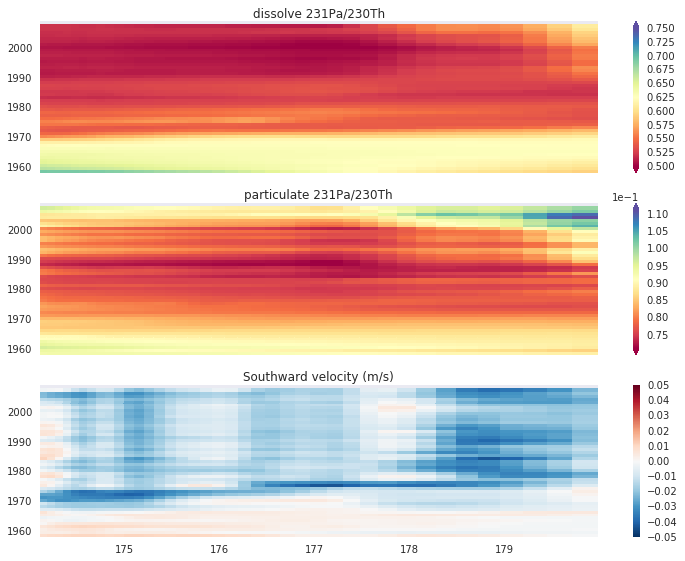

In [78]:
# make plots
fig = plt.figure(figsize=(15/1.2,15/1.2))
ax=plt.subplot(4,1,1)
plt.pcolor(coor[:],time_plt[:],Temp[:,:],cmap='Spectral',vmax=0.75,vmin=0.50)#,v,vmin=vmin,vmax=vmax,cmap=plt.cm.Spectral_r);
cbar=plt.colorbar(extend='both')
ax.get_xaxis().set_ticklabels([])
plt.title('dissolve 231Pa/230Th');plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()
        
ax=plt.subplot(4,1,2)
plt.pcolor(coor[:],time_plt[:],pTemp[:,:],cmap='Spectral');cbar=plt.colorbar(extend='both')
ax.get_xaxis().set_ticklabels([])
plt.title('particulate 231Pa/230Th');plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-1, 1))
cbar.update_ticks()

#ax=plt.subplot(4,1,3)
#plt.pcolor(vlat,time_plt,uhold,cmap='Spectral_r',vmin=-0.05,vmax=0.05)
#plt.colorbar();plt.title('Along-shore velocity (m/s)');
#plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())

ax=plt.subplot(4,1,3)
plt.pcolor(vlat,time_plt,vhold,cmap='RdBu_r',vmin=-0.05,vmax=0.05)
plt.colorbar();plt.title('Southward velocity (m/s)');
plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())

# EB tracer 

In [14]:
temp,coor=section_hovmoller(data=ptrc.variables['TR_7'],layer=35,x0=-230,y0=358,length=100,xi=1,yi=0.2)
temp2,coor=section_hovmoller(data=ptrc.variables['TR_8'],layer=35,x0=-230,y0=358,length=100,xi=1,yi=0.2)
# vel
uhold,vlat= uvelocity_hov(layer=35,x0=-230,y0=358,length=100,xi=1,yi=0.2)
vhold,vlat= vvelocity_hov(layer=35,x0=-230,y0=358,length=100,xi=1,yi=0.2)

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__

In [15]:
Temp=temp[:,:]/temp2[:,:]
Temp=np.ma.masked_where(temp==0,Temp)

In [16]:
ptemp1,coor=section_hovmoller(data=ptrc.variables['TR_9'],layer=35,x0=-230,y0=358,length=100,xi=1,yi=0.2)
ptemp1=np.ma.masked_where(ptemp1==0,ptemp1)
ptemp2,coor=section_hovmoller(data=ptrc.variables['TR_10'],layer=35,x0=-230,y0=358,length=100,xi=1,yi=0.2)
ptemp2=np.ma.masked_where(ptemp2==0,ptemp2)

pTemp=ptemp1[:,:]/ptemp2[:,:]
pTemp=np.ma.masked_where(pTemp==0,pTemp)

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(41.505165100097656, 116.45134735107422)

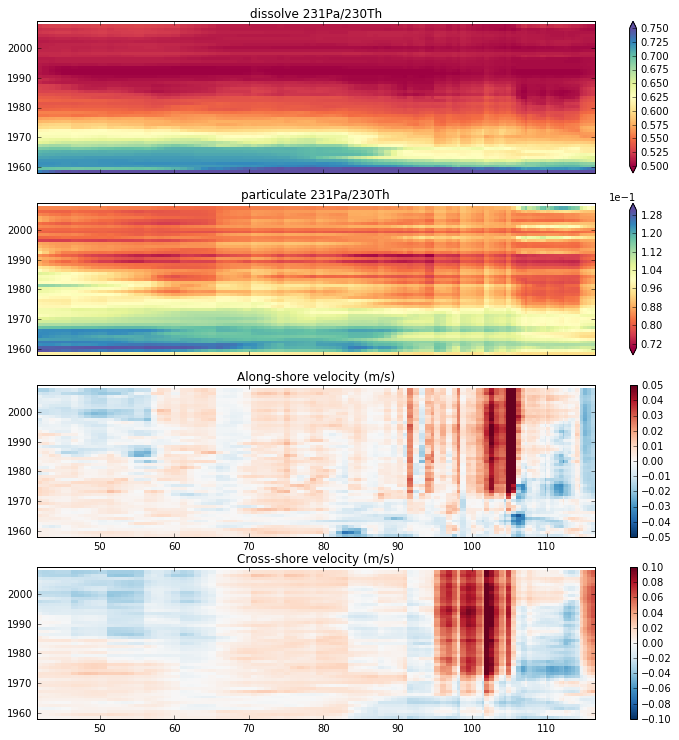

In [20]:
# make plots
fig = plt.figure(figsize=(15/1.2,15/1.2))
ax=plt.subplot(4,1,1)
plt.pcolor(coor[:],time_plt[:],Temp[:,:],cmap='Spectral',vmax=0.75,vmin=0.50)#,v,vmin=vmin,vmax=vmax,cmap=plt.cm.Spectral_r);
cbar=plt.colorbar(extend='both')
ax.get_xaxis().set_ticklabels([])
plt.title('dissolve 231Pa/230Th');plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()
        
ax=plt.subplot(4,1,2)
plt.pcolor(coor[:],time_plt[:],pTemp[:,:],cmap='Spectral');cbar=plt.colorbar(extend='both')
ax.get_xaxis().set_ticklabels([])
plt.title('particulate 231Pa/230Th');plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-1, 1))
cbar.update_ticks()

ax=plt.subplot(4,1,3)
plt.pcolor(vlat,time_plt,uhold,cmap='RdBu_r',vmin=-0.05,vmax=0.05)
plt.colorbar();plt.title('Along-shore velocity (m/s)');
plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())

ax=plt.subplot(4,1,4)
plt.pcolor(vlat,time_plt,vhold,cmap='RdBu_r',vmin=-0.1,vmax=0.1)
plt.colorbar();plt.title('Cross-shore velocity (m/s)');
plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())

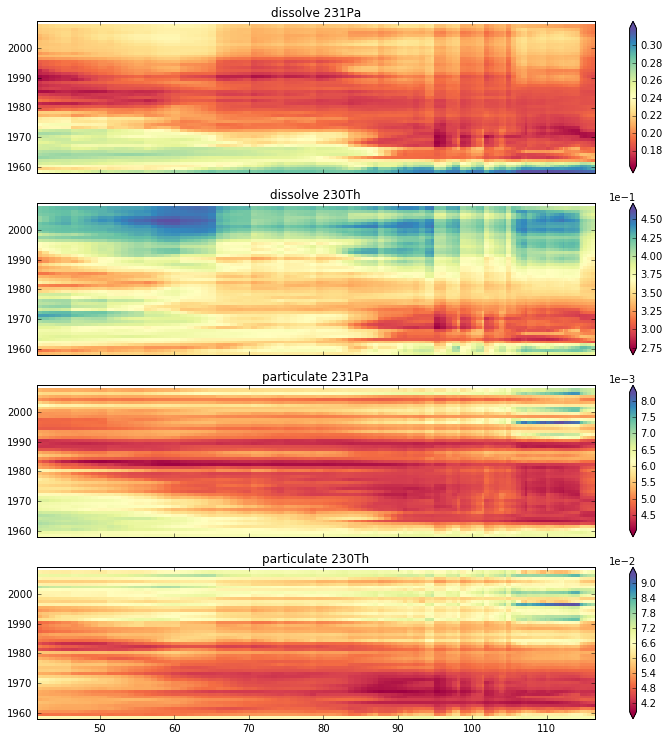

In [40]:
fig = plt.figure(figsize=(15/1.2,15/1.2))
ax=plt.subplot(4,1,1)
plt.pcolormesh(coor[:],time_plt[:],temp[:,:],cmap='Spectral')#,v,vmin=vmin,vmax=vmax,cmap=plt.cm.Spectral_r);
cbar=plt.colorbar(extend='both')
ax.get_xaxis().set_ticklabels([])
plt.title('dissolve 231Pa');plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()
        
ax=plt.subplot(4,1,2)
plt.pcolormesh(coor[:],time_plt[:],temp2[:,:],cmap='Spectral');cbar=plt.colorbar(extend='both')
ax.get_xaxis().set_ticklabels([])
plt.title('dissolve 230Th');plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-1, 1))
cbar.update_ticks()


ax=plt.subplot(4,1,3)
plt.pcolormesh(coor[:],time_plt[:],ptemp1[:,:],cmap='Spectral')#,v,vmin=vmin,vmax=vmax,cmap=plt.cm.Spectral_r);
cbar=plt.colorbar(extend='both')
ax.get_xaxis().set_ticklabels([])
plt.title('particulate 231Pa');plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()
        
ax=plt.subplot(4,1,4)
plt.pcolormesh(coor[:],time_plt[:],ptemp2[:,:],cmap='Spectral');cbar=plt.colorbar(extend='both')
plt.title('particulate 230Th');plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-1, 1))
cbar.update_ticks()

# CB

In [41]:
temp,coor=section_hovmoller(data=ptrc.variables['TR_7'],layer=35,x0=280,y0=170,length=40,xi=-2,yi=1.5)
temp2,coor=section_hovmoller(data=ptrc.variables['TR_8'],layer=35,x0=280,y0=170,length=40,xi=-2,yi=1.5)

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


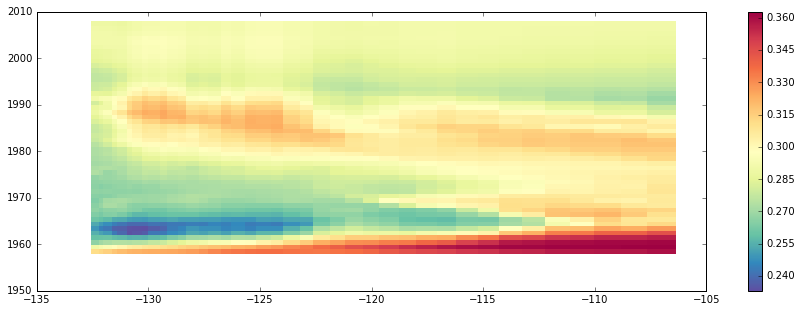

In [42]:
fig = plt.figure(figsize=(15,5))
temp=np.ma.masked_where(temp==0,temp)
plt.pcolor(coor[:],time_plt[:],temp[:,:],cmap='Spectral_r')#,v,vmin=vmin,vmax=vmax,cmap=plt.cm.Spectral_r);
plt.colorbar()

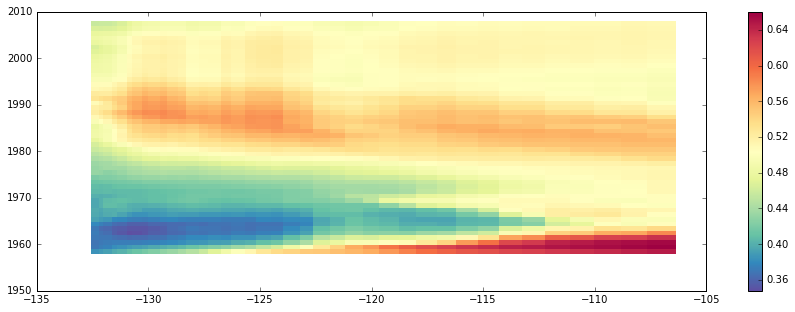

In [43]:
fig = plt.figure(figsize=(15,5))
temp2=np.ma.masked_where(temp2==0,temp2)
plt.pcolor(coor[:],time_plt[:],temp2[:,:],cmap='Spectral_r');plt.colorbar()

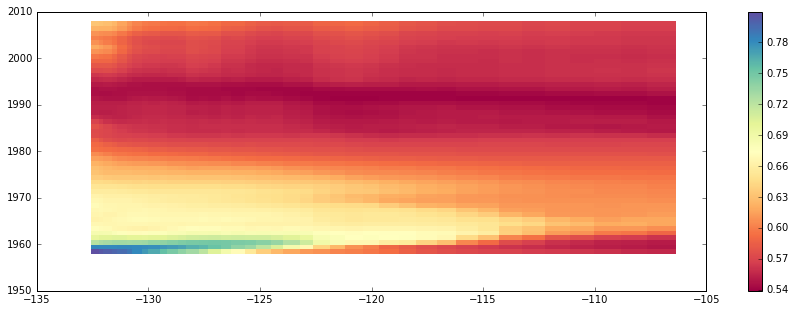

In [44]:
fig = plt.figure(figsize=(15,5))
Temp=temp[:,:]/temp2[:,:]
Temp=np.ma.masked_where(temp==0,Temp)
plt.pcolor(coor[:],time_plt[:],Temp,cmap='Spectral')
plt.colorbar()

It seems that the hovmoller plot is not as efficient as the line plot because the linear increase trend in Pa.

In [45]:
uhold,vlat= uvelocity_hov(layer=35,x0=280,y0=170,length=40,xi=-2,yi=1.5)
vhold,vlat= vvelocity_hov(layer=35,x0=280,y0=170,length=40,xi=-2,yi=1.5)

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


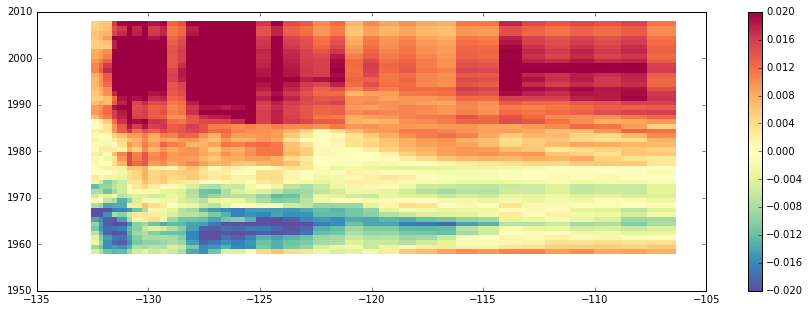

In [46]:
fig = plt.figure(figsize=(15,5))
plt.pcolor(vlat,time_plt,uhold,cmap='Spectral_r',vmin=-0.02,vmax=0.02)
plt.colorbar()

In [47]:
ptemp1,coor=section_hovmoller(data=ptrc.variables['TR_9'],layer=35,x0=280,y0=170,length=40,xi=-2,yi=1.5)
ptemp1=np.ma.masked_where(ptemp1==0,ptemp1)
ptemp2,coor=section_hovmoller(data=ptrc.variables['TR_10'],layer=35,x0=280,y0=170,length=40,xi=-2,yi=1.5)
ptemp2=np.ma.masked_where(ptemp2==0,ptemp2)

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [48]:
pTemp=ptemp1[:,:]/ptemp2[:,:]
pTemp=np.ma.masked_where(pTemp==0,pTemp)

# CB2 <a id='another_cell'></a>

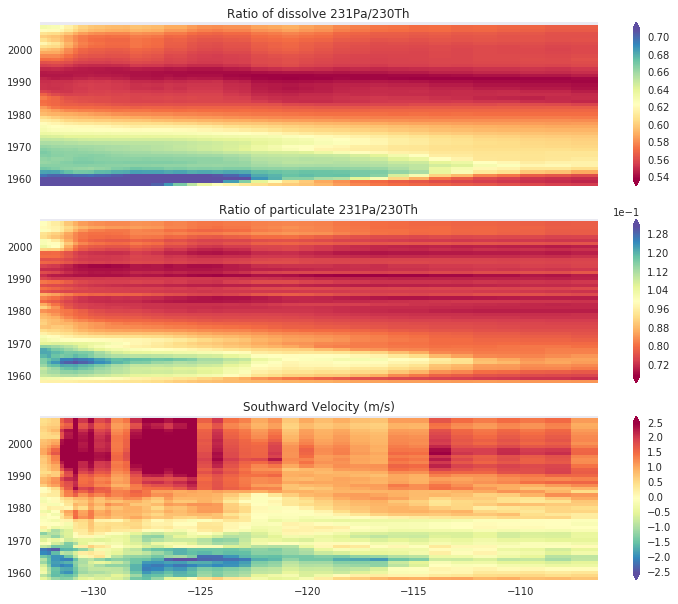

In [49]:
import seaborn as sns

fig = plt.figure(figsize=(15/1.2,12/1.2))

ax=plt.subplot(3,1,1)
plt.pcolormesh(coor[:],time_plt[:],Temp[:,:],cmap='Spectral',vmax=0.71)#,v,vmin=vmin,vmax=vmax,cmap=plt.cm.Spectral_r);
cbar=plt.colorbar(extend='both')
ax.get_xaxis().set_ticklabels([])
plt.title('Ratio of dissolve 231Pa/230Th');plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()
        
        
ax=plt.subplot(3,1,2)


plt.pcolormesh(coor[:],time_plt[:],pTemp[:,:],cmap='Spectral');cbar=plt.colorbar(extend='both')
ax.get_xaxis().set_ticklabels([])
plt.title('Ratio of particulate 231Pa/230Th');plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-1, 1))
cbar.update_ticks()


ax=plt.subplot(3,1,3)
plt.pcolormesh(vlat,time_plt,uhold*100,cmap='Spectral_r',vmin=-2.5,vmax=2.5)
cbar=plt.colorbar(extend='both')
plt.title('Southward Velocity (m/s)');plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())
#cbar.set_label('southward veolocity (cm/s)')
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()


In [50]:
print (dep[35])

1062.44


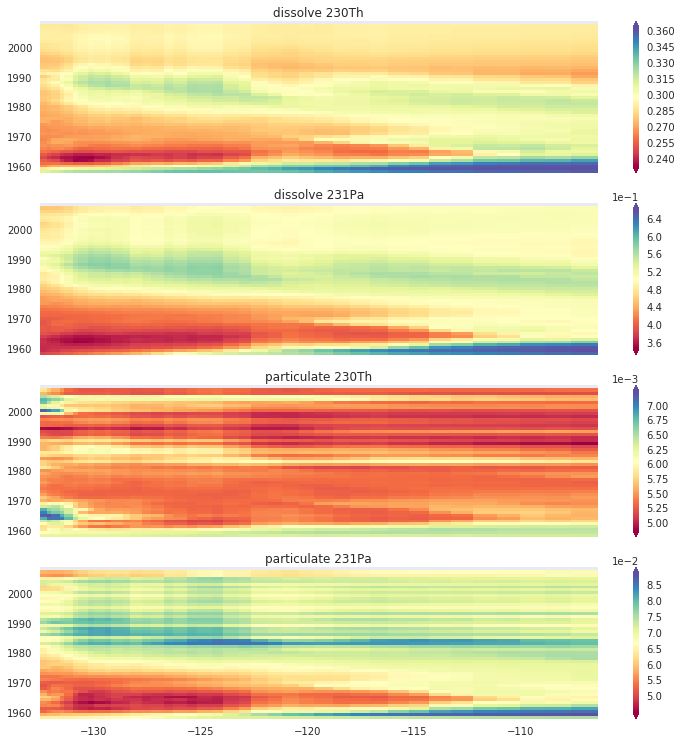

In [51]:
fig = plt.figure(figsize=(15/1.2,15/1.2))
ax=plt.subplot(4,1,1)
plt.pcolormesh(coor[:],time_plt[:],temp[:,:],cmap='Spectral')#,v,vmin=vmin,vmax=vmax,cmap=plt.cm.Spectral_r);
cbar=plt.colorbar(extend='both')
ax.get_xaxis().set_ticklabels([])
plt.title('dissolve 230Th');plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()
        
ax=plt.subplot(4,1,2)
plt.pcolormesh(coor[:],time_plt[:],temp2[:,:],cmap='Spectral');cbar=plt.colorbar(extend='both')
ax.get_xaxis().set_ticklabels([])
plt.title('dissolve 231Pa');plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-1, 1))
cbar.update_ticks()


ax=plt.subplot(4,1,3)
plt.pcolormesh(coor[:],time_plt[:],ptemp1[:,:],cmap='Spectral')#,v,vmin=vmin,vmax=vmax,cmap=plt.cm.Spectral_r);
cbar=plt.colorbar(extend='both')
ax.get_xaxis().set_ticklabels([])
plt.title('particulate 230Th');plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()
        
ax=plt.subplot(4,1,4)
plt.pcolormesh(coor[:],time_plt[:],ptemp2[:,:],cmap='Spectral');cbar=plt.colorbar(extend='both')
plt.title('particulate 231Pa');plt.ylim(1958,1958+yearnum);plt.xlim(vlat.min(),vlat.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-1, 1))
cbar.update_ticks()